# 0. Import Packages and Load Predefined Functions 

In [44]:
import sys
sys.path.insert(1, 'C:\Development\Deals Analytics R&D')

import functions
from functions.outliers import outliers, median_substitute_outliers
from functions.linear_regression import linear_regression
from functions.HWES import HWES
from functions.get_cashflow_table import get_cashflow_table
from functions.get_discounted_cashflows import get_discounted_cashflows
from functions.get_predictions import get_predictions
from functions.get_sensitivity_plot import get_sensitivity_plot
from functions.get_tax import get_tax
from functions.calc_npv import calc_npv
from scipy.stats import skew
import numpy_financial as npf
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.stats import triang as triang
from matplotlib.pyplot import figure
from scipy import stats
import math

## 1. Input Parameters

In [45]:
############################################# INPUT #######################################################################

# Corporate income tax rate
tax_rate = 25

# Weighted average cost of capital (discouting factor)
yearly_wacc = 10
monthly_wacc = 0.797414042890376

# Confidence level of boundries
confidence_level = 0.95
confidence_interval = 0.95

# Number of simulations
iters = 100

# Lambda definition for kurtosis determination of beta-PERT distribution, see: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79
lamb = 4

distribution = 'Gaussian'

In [46]:
# Format
plt.style.use('seaborn-whitegrid')
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

## 2. Load Data & Set Parameters

In [47]:
df_pred = pd.read_excel(r'C:\Development\Deals Analytics R&D\DCF_Cashflows.xlsx', sheet_name='Sheet1')
df_pred

,Revenue - Regular Sales - lower,Revenue - Regular Sales - expected,Revenue - Regular Sales - upper,COGS - Regular Sales - lower,COGS - Regular Sales - expected,COGS - Regular Sales - upper,COGS - Intermediate Sales - lower,COGS - Intermediate Sales - expected,COGS - Intermediate Sales - upper,OPEX - Inventory Revaluation - lower,...,OPEX - Other - upper,DA - Depreciations - lower,DA - Depreciations - expected,DA - Depreciations - upper,Investments - Totals - lower,Investments - Totals - expected,Investments - Totals - upper,Change in NWC - lower,Change in NWC - expected,Change in NWC - upper
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.657500e+06,-1.841667e+06,-2.025833e+06,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.657500e+06,-1.841667e+06,-2.025833e+06,0.000000,0.000000,0.000000
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.657500e+06,-1.841667e+06,-2.025833e+06,0.000000,0.000000,0.000000
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.657500e+06,-1.841667e+06,-2.025833e+06,0.000000,0.000000,0.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.657500e+06,-1.841667e+06,-2.025833e+06,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1.003769e+07,1.115298e+07,2.717768e+07,-3.401045e+06,-3.778939e+06,-4.156832e+06,-3318.050459,-3686.722732,-4055.395006,-4876.862813,...,-173310.758790,-798367.705625,-9.979596e+05,-1.197552e+06,-4.042074e+05,-4.491193e+05,-4.940313e+05,45960.020557,51066.689507,56173.358458
356,1.041334e+07,1.157038e+07,2.728639e+07,-3.528328e+06,-3.920365e+06,-4.312401e+06,-3442.228007,-3824.697785,-4207.167564,-5085.332413,...,-171357.818860,-798955.759346,-9.986947e+05,-1.198434e+06,-4.048750e+05,-4.498611e+05,-4.948472e+05,-1289.767580,-1433.075089,-1576.382598
357,1.043054e+07,1.158949e+07,2.739554e+07,-3.534156e+06,-3.926840e+06,-4.319524e+06,-3447.913126,-3831.014584,-4214.116043,-5118.831413,...,-172028.714773,-799544.784286,-9.994310e+05,-1.199317e+06,-4.055437e+05,-4.506041e+05,-4.956645e+05,281260.548867,312511.720963,343762.893059
358,1.008750e+07,1.120834e+07,2.750512e+07,-3.417924e+06,-3.797693e+06,-4.177462e+06,-3334.517716,-3705.019685,-4075.521653,-4901.066350,...,-171861.964405,-800134.782048,-1.000168e+06,-1.200202e+06,-4.062135e+05,-4.513483e+05,-4.964831e+05,-210985.582531,-234428.425035,-257871.267538


In [48]:
## check if every columns has OR lower OR upper OR expected
## check if there are columns with 'Investments', 'Change in NWC' and 'Depreciations'
## check that there is NO tax column, NO ebitda, NO ebita

In [49]:
#for i in range(len(df_pred.columns)):
#    columnames1.append(df_pred.columns[i].rsplit(' -', 1)[0])

In [50]:
columnames1 = []
for i in range(len(df_pred.columns)):
    columnames1.append(df_pred.columns[i].rsplit(' -', 1)[0])
columnames1

columnames = []
for i in columnames1:
    if i not in columnames:
        columnames.append(i)
        
columnames

['Revenue - Regular Sales',
 'COGS - Regular Sales',
 'COGS - Intermediate Sales',
 'OPEX - Inventory Revaluation',
 'OPEX - Energy costs - Sorting',
 'OPEX - Energy costs - Recycling',
 'OPEX - Energy costs',
 'OPEX',
 'OPEX - Real estate',
 'OPEX - Insurance',
 'OPEX - Disposal',
 'OPEX - Waste water',
 'OPEX - Packaging',
 'OPEX - Internal transportation',
 'OPEX - Staff costs soritng',
 'OPEX - Staff costs recycling',
 'OPEX - Other',
 'DA - Depreciations',
 'Investments - Totals',
 'Change in NWC']

## Functions

In [51]:
# Define function that simulated between boundries

def simulate_within_boundries_triangle(df, iters):
    """Triangle distributions are common used in modeling expert-given upper, expected and lower statistics. 
    For this function, please insert df (data), iters (number of data points to be generated) and confidence level fo the boundries.
    Source: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79"""
    df_sim = pd.DataFrame({}, index=range(len(df)), columns=range(iters))
    for i in range(len(df)):
        x = df.iloc[i,:]  

        # Give 0s for cases where expected/lower/upper is 0
        if x[0] - x[2] == 0:
            df_sim.iloc[i] = 0.0
        
        else:
            # Simulate and write back in a new df --> df_sim
            df_sim.iloc[i] = np.random.triangular(x[0], x[1], x[2], iters)
            
            # Rename columns with simulation counts
            for cols in df_sim:
                cols = '{}'.format(df.columns[1])+'_'+'{}'.format(df_sim.columns[i])

    return df_sim

In [52]:
# Definition of data generation function for triangular distribution

def simulate_triangle_distribution(df, iters, confidence_level):
    """Triangle distributions are often used for generating data having expert-given upper, expected and lower statistics. 
    For this function, please insert df (data), iters (number of data points to be generated) and confidence level fo the boundries.
    Source: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79"""
    
    df_sim = pd.DataFrame({}, index=range(len(df)), columns=range(iters))
    for i in range(len(df)):
        x = df.iloc[i,:]
        
        # Exclude cases where upper,expected,lower = 0
        if x[0] - x[2] == 0:
            df_sim.iloc[i] = 0.0
        
        else:
            # Estimate the shape parameter from the data
            shape = (x[1] - x[0]) / (x[2] - x[0])
            
            # Calculate lower and upper bounds for the triangular distribution at the given confidence level
            lower_bound, upper_bound = triang.interval(confidence_level, c=shape, loc=x[0], scale=x[2]-x[0])
            
            # Generate random numbers from a triangular distribution within the calculated bounds
            data = triang.rvs(c=shape, loc=x[0], scale=x[2]-x[0], size=iters)
            data = data[(data >= lower_bound) & (data <= upper_bound)]
            df_sim.iloc[i] = data
            
            # Rename columns with simulation counts            
            for cols in df_sim:
                cols = '{}'.format(df.columns[1])+'_'+'{}'.format(df_sim.columns[i])

    return df_sim

In [53]:
def pert(mini, mode, maxi, iters, lamb):
    """Pert distributions are a more bell-curved alternative for the triangle distribution, usable for generating data having expert-given upper, expected and lower statistics. 
    For this function, please insert df (data), iters (number of data points to be generated) and confidence level fo the boundries.
    Source: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79"""   
    
    r = maxi - mini
    simu = []
    
    # Exclude cases where upper,expected,lower = 0
    for i in range(iters):
        if r == 0 or math.isnan(r):
            r = 1
            
        alpha = (1 + lamb * (mode - mini) / r)
        beta =  (1 + lamb * (maxi - mode) / r)
        
        if alpha > 0 and beta > 0: 
            sim = mini + np.random.beta(alpha, beta) * r
        elif alpha <= 0:
            alpha = 0.00001
            sim = mini + np.random.beta(alpha, beta) * r
        elif beta <= 0:
            beta = 0.00001
            sim = mini + np.random.beta(alpha, beta) * r
        elif beta <= 0 and alpha <= 0:
            sim = mode
        
        simu.append(sim)
    return simu

In [54]:
import numpy as np

def pert_simulation(min_val, mode_val, max_val, iterations, pert_beta=1):
    alpha = pert_beta
    beta = alpha ** 2
    gamma = alpha * 4
    mean = (min_val + alpha * mode_val + max_val) / (alpha + beta + 1)
    sigma = (gamma * (max_val - min_val)) / (alpha + beta + 1)
    sigma = max(sigma, 1e-9) # ensure sigma is positive
    noise = np.random.normal(0, sigma / 2, iterations)
    data = mean + noise
    data = np.clip(data, min_val, max_val)
    return data

In [55]:
def generate_gaussian_numbers(min_val, max_val, expected_value,iters): 
    if min_val > max_val:
        l = min_val
        p = max_val
        max_val = l
        min_val = p
    mean = (min_val + max_val) / 2
    range_ = max(max_val - min_val, 0.001)  # Ensure positive range
    std = range_ / 4  # Approximate standard deviation
    skewness = (expected_value - mean) / std
    return np.clip(np.random.normal(loc=mean, scale=std, size=iters) + skewness * std, min_val, max_val)

In [56]:
def simulate_gaussian(df, iters): 
    """Function that simulates a beta-PERT distribution, where input parameters are df (data), 
    iters (number of datapoints to generate) and lamb, which defines the kurtosis of the distribution (4 is most commonly used).
    For more information on the beta-PERT distribution, see: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79"""
    
    df_sim = pd.DataFrame({}, index=range(len(df)), columns=range(iters))
    
    # Generate datapoints for all years
    for i in range(len(df)):
        x = df.iloc[i,:]  
        
        # Write into new dataframe df_sim
        df_sim.iloc[i] = generate_gaussian_numbers(x[0], x[2], x[1], iters)

    return df_sim

In [57]:
def simulate_beta_pert(df, iters, lamb): 
    """Function that simulates a beta-PERT distribution, where input parameters are df (data), 
    iters (number of datapoints to generate) and lamb, which defines the kurtosis of the distribution (4 is most commonly used).
    For more information on the beta-PERT distribution, see: https://towardsdatascience.com/python-scenario-analysis-modeling-expert-estimates-with-the-beta-pert-distribution-22a5e90cfa79"""
    
    df_sim = pd.DataFrame({}, index=range(len(df)), columns=range(iters))
    
    # Generate datapoints for all years
    for i in range(len(df)):
        x = df.iloc[i,:]  
        
        # Write into new dataframe df_sim
        df_sim.iloc[i] = pert_simulation(x[0], x[1], x[2], iters)
        #df_sim.iloc[i] = pert_simulation(x[0], x[1], x[2], iters)

    return df_sim

In [58]:
# Fix processing count of i

# Initialize a list to store the data for each column
def get_simulation_results_pl(df, iters, lamb, distribution):
    """Function to generate simulation results, by default uses a beta-PERT distribution. When triangle = True, it wil substitude the beta-PERT for a triangular distribution.
    Besides the optional triangle boolean, df (data), lamb (kurtosis of beta-PERT distribution, by default 4) and iters are mandatory input parameters."""
    
    # Iterate through the columns
    sim_result = pd.DataFrame()
    for i in range(0, df.shape[1],3):
        
        # Extract the data for the current column
        data = df.iloc[:, i:i+3]
        name = data.columns[1].rsplit(' -', 1)[0]
        print(f'Processing variable: {name}')          
        
        # Determination of simulation logic
        if distribution == 'Pert':
            df_sim = simulate_beta_pert(data, iters, lamb)
        elif distribution == 'Triangle':
            df_sim = simulate_within_boundries_triangle(data, iters)
        elif distribution == 'Gaussian':
            df_sim = simulate_gaussian(data, iters)

        # And add a column count for interpretability and validity purposes  
        for cols in df_sim:
            df_sim = df_sim.rename(columns = {cols:'{}'.format(name)+'_sim_'+'{}'.format(df_sim.columns[cols])})
        # Finally concat to prior results
        df_sim = pd.DataFrame(np.sort(df_sim.values, axis=1), index=df_sim.index, columns=df_sim.columns)
        sim_result = pd.concat([sim_result, df_sim], axis=1)
        
        
        
    return sim_result

In [59]:
def plot_simulations(df, df_original):
    """Visualizes the simulated with correspodning descriptive statistics by plotting boxplots for each t, combined with the original upper, expected, lower values.
    Input variables are the simulated results """
    # plot logic
    rows = []
    
    # Prep data  
    df = df/1000
    df_original = df_original/1000
    #df = round(df.groupby(df.index // 12).sum(),2)
    #df_original = round(df_original.groupby(df_original.index // 12).sum(),2)      
    
    # Iterate through the rows of the DataFrame
    for index, row in df.iterrows():
        # Append the row data to the list as a list
        rows.append(list(row))
    
    data = rows
     
    fig = plt.figure(figsize =(8, 4))
     
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Creating plot
    bp = ax.plot(data, color="lightgrey")
    bp = ax.plot(df_original.iloc[:,:3], color='darkblue')
    
    # format boxplots
    medianprops = dict(linestyle='-', linewidth=4, color='magenta', label = 'Simulation median')
    meanpointprops = dict(marker='^', linewidth=1, markersize=6, markeredgecolor='black',markerfacecolor='cyan', label = 'Simulation mean')   
    positions = range(0, len(df), 1)
    bp = ax.boxplot(data, notch=True, positions = positions, medianprops=medianprops, meanprops=meanpointprops, showmeans=True)

    # set the graph labels
    plt.ylabel("Expected amount (€ thousand)",fontsize=14)
    plt.xlabel("Upcoming periods (FY)",fontsize=14)
    plt.title(f"{df_original.iloc[:,:].columns[1].split('-')[0] +'-'+df_original.iloc[:,:].columns[1].split('-')[1][:-1]}, expected outcomes & simulations", fontsize=18,fontweight="bold")
    
    # Avoid duplicate legend items
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Plot
    plt.show()

In [60]:
# The TAX is calculated on the EBITA (so EBITDA - depreciations and WITHOUT Change NWC and investments)
def get_tax_for_tax_related_columns(df, iters):
    
    # Extract column contaiming Depreciations
    matches = []
    for match in columnames:
        if "Depreciations" in match:
            matches.append(match)
    
    # iterate through rows
    for i in range(0,iters):
        
        # Create n_iter columns that calculates all
        data = df.drop(columns = df.filter(regex='Change in NWC').columns)
        data = data.drop(columns = df.filter(regex='Investments').columns)
        data = data.drop(columns = df.filter(regex='Depreciations').columns)


        df[f'ebitda_sim_{i}'] = data.filter(regex=f'sim_{i}$').sum(axis=1)
        
    for i in range(0,iters):   
        df[f'ebita_sim_{i}'] = df[f'ebitda_sim_{i}'] + df[f'{matches[0]}_sim_{i}']
        
        # Alternative for if statement to calculate tax only when monthly EBIT > 0
        conditions = [(df[f'ebita_sim_{i}'] <= 0),(df[f'ebita_sim_{i}'] > 0)]
        values = [0, (df[f'ebita_sim_{i}']*(tax_rate/100)*-1)]
        
        # Execute calculation
        df[f'tax_sim_{i}'] = np.select(conditions, values)
        
        # Drop the unnecessary columns
  
    return df

In [61]:
# Calculate 1000 NPvs

def calculate_npv_simulations(df, iters, monthly_wacc):
    
    # Extract columnames with Change in NWC and Investments
    matches_c = []
    for match in columnames:
        if "Change in NWC" in match:
            matches_c.append(match)
    
    matches_i = []
    for match in columnames:
        if "Investments" in match:
            matches_i.append(match)
    
    colums = []
    for i in range(0,iters):
        colums.append(f'npv_{i}')

    npvs = pd.DataFrame(index= colums) 
    npvs_list = []

    for i in range(0,iters):
        data = df.filter(regex = f'sim_{i}$')
        cashflows = list(data.loc[:,f'ebitda_sim_{i}'] + data.loc[:,f'tax_sim_{i}'] 
                         + data.loc[:,f'Investments - Totals_sim_{i}'] - data.loc[:,f'{matches_c[0]}_sim_{i}'])
        cashflows = [0] + cashflows # Investment is null
        npvs_list.append(npf.npv(monthly_wacc/100, cashflows))

    npvs['npvs'] = npvs_list
    
    return npvs

In [62]:
def calculate_expected_npv(df, monthly_wacc):    
    
    df_pred_exp = df.filter(regex = 'expected')
    data = df_pred_exp.drop(columns = df_pred_exp.filter(regex='Change in NWC').columns)
    data = data.drop(columns = data.filter(regex='Investments').columns)
        
    data = data.drop(columns = data.filter(regex='Depreciations').columns)

    df_pred_exp[f'ebitda - expected'] = data.sum(axis=1)

    df_pred_exp[f'ebita - expected'] = df_pred_exp[f'ebitda - expected'] + df_pred_exp[f'DA - Depreciations - expected']

    ## Only pay corporate income tax in case of positive annual EBIT
    conditions = [(df_pred_exp[f'ebita - expected'] <= 0),(df_pred_exp[f'ebita - expected'] > 0)]

    ## Calculate tax value
    values = [0, (df_pred_exp[f'ebita - expected'])*(tax_rate/100)*-1]

    ## Write values into new column
    df_pred_exp['Corporate Tax - expected'] = np.select(conditions, values)

    cashflows = [0] + list(df_pred_exp.loc[:,f'ebitda - expected'] + df_pred_exp.loc[:,f'Corporate Tax - expected'] 
                         + df_pred_exp.loc[:,f'Investments - Totals - expected'] - df_pred_exp.loc[:,f'Change in NWC - expected'])
    cashflows_exp = cashflows.copy()
    npv_exp = npf.npv(monthly_wacc/100, cashflows)
    
    return npv_exp, cashflows_exp, df_pred_exp

In [63]:
def plot_cashflows(df_simulations, df_cashflows_expected, iters):
    cashflows_sim = []
    
    for i in range(0,iters):
        #cashflows_sim.append(df_simulations.filter(regex = f'sim_{i}$').iloc[:,-2:].sum(axis=1))
        cashflows_sim.append(df_sim_results.loc[:, f'ebitda_sim_{i}'] + df_sim_results.loc[:,f'tax_sim_{i}'] 
                             + df_sim_results.loc[:,f'Investments - Totals_sim_{i}'] 
                             - df_sim_results.loc[:,f'Change in NWC_sim_{i}'])

        
    # add boxplots on x axis

    fig = plt.figure(figsize =(8, 4))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    plt.plot((pd.DataFrame(cashflows_sim).T/1000000), color = 'lightgray')
    plt.plot((pd.DataFrame(df_cashflows_expected[1:])/1000000), label = 'Expected', color = 'darkblue')

    #positions = range(0, (len(df_sim_results)),1)

    # format boxplots
    medianprops = dict(linestyle='-', linewidth=5, color='magenta', label = 'median')
    meanpointprops = dict(marker='^', linewidth=1, markersize=8, markeredgecolor='black', markerfacecolor='cyan', label = 'mean')   

    # set the graph labels
    plt.ylabel("Expected amount (€ million)", fontsize=14)
    plt.xlabel("Upcoming periods (FY)",fontsize=14)
    plt.title(f"Future cashflows - expected outcomes & simulations", fontsize=18,fontweight="bold")


    plt.legend()
    plt.show()    
    return cashflows_sim

In [64]:
import plotly.graph_objs as go

def plot_sensitivity(df, columnames, yearly_wacc):

    df_sens = df_sim_results[df_sim_results.columns.drop(list(df_sim_results.filter(regex='ebit_cashflow')))]
    
    df_npv_input1 = pd.DataFrame()

    if 'tax' not in list(columnames):
        columnames = list(columnames) + ['tax']

    for column in columnames:

        df_npv_input1[f'{column} - lower'] = df_sens.filter(regex=f'^{column}_sim').min(axis = 1)
        df_npv_input1[f'{column} - upper'] = df_sens.filter(regex=f'^{column}_sim').max(axis = 1)
        df_npv_input1[f'{column} - expected'] = df_sens.filter(regex=f'^{column}_sim').mean(axis = 1)

    df_predict = df_npv_input1.copy()

    df_predict['discount_factor'] = 1 / (1 + yearly_wacc) ** (np.arange(0, len(df_predict)) / 12)

    for i in df_predict.filter(regex =r'(upper|lower|expected)').columns:
        df_predict[i + ' - discounted'] = df_predict[i] * df_predict['discount_factor']

    #df_predict = df_predict.reindex(sorted(df_predict.columns), axis=1)

    df_npv_input = pd.DataFrame(columns = ['variable','lower','expected','upper'])

    for column in columnames:
        lower = int(df_predict.filter(regex = f'^{column} - lower').filter(regex = 'discounted').sum())
        expected = int(df_predict.filter(regex = f'^{column} - expected').filter(regex = 'discounted').sum())
        upper    = int(df_predict.filter(regex = f'^{column} - upper').filter(regex = 'discounted').sum())
        df_npv_input = df_npv_input.append({'variable': column, 'lower':lower, 'expected': expected ,'upper': upper},
                                           ignore_index=True)

    df_npv_input['NPV'] = df_npv_input['expected'].sum()

    df_npv_input['NPV_low'] = (df_npv_input['NPV'] - (df_npv_input['expected']) + df_npv_input['lower'])
    df_npv_input['NPV_upper'] = (df_npv_input['NPV'] - (df_npv_input['expected']) + df_npv_input['upper'])
    df_npv_input['NPV_range'] = abs(df_npv_input['lower'] - df_npv_input['upper'])
    df_npv_input = df_npv_input.sort_values(by='NPV_range').reset_index(drop=True)
    
    # drop the strings with depreciation that do not contain 'NEG'
    import re
    pattern = re.compile("Depreciation.*NEG", re.IGNORECASE)
    mask = df_npv_input['variable'].str.contains(pattern)

    # Use the mask to drop the rows that match the pattern
    df_npv_input = df_npv_input[~mask]

    # Prep
    variable_upper_values    = df_npv_input['upper']
    variable_names           = df_npv_input['variable']
    variable_expected_values = df_npv_input['expected']
    variable_lower_values    = df_npv_input['lower']
    lower_npv                = df_npv_input['NPV_low']
    upper_npv                = df_npv_input['NPV_upper']
    expected_npv             = list(df_npv_input['NPV'])[0]
    
    fig = go.Figure()
    fig.add_vline(x=npv_exp, line_width=3, line_color="black",annotation_text="", 
                  annotation_position="bottom right", name = 'Expected')
    fig.add_trace(go.Bar(y=variable_names, x=upper_npv-expected_npv,
                    base=npv_exp,
                    marker_color='rgb(158,202,225)',
                    name=f'{100*confidence_level}% CI Upper Bound',
                    marker_line_color='rgb(8,48,107)',
                    orientation='h',
                    marker_line_width=1.5,
                    opacity= 0.7,
                    text = variable_upper_values,
                    textposition='inside',
                    insidetextanchor="start",
                    #texttemplate = "%{x:,s} "
    ))
    fig.add_trace(go.Bar(y=variable_names, x=lower_npv-expected_npv,
                    base=npv_exp,
                    marker_color='crimson',
                    name=f'{100*confidence_level}% CI Lower Bound',
                    marker_line_color='red',
                    orientation='h',
                    marker_line_width=1.5,
                    opacity= 0.7,
                    text = variable_lower_values,
                    textposition='inside',
                    insidetextanchor="start"
                    #texttemplate = "%{x:,s} "
    ))
    fig.update_layout(
        height=600,
         margin=dict(t=50,l=10,b=10,r=10),
    title_text=f'NPV Sensitivity Analysis with expected NPV €{round(npv_exp)}',
     title_font_family="sans-serif",
     #legend_title_text='Financials',
     title_font_size = 25,
     title_font_color="darkblue",
     title_x=0.5 #to adjust the position along x-axis of the title
    )
    fig.update_layout(barmode='overlay', 
                      xaxis_tickangle=-45, 
                       legend=dict(
                         x=1,
                         y=0.01,
     bgcolor='rgba(255, 255, 255, 0)',
     bordercolor='rgba(255, 255, 255, 0)'
     ),
                      yaxis=dict(
     title='Factors',
     titlefont_size=16,
     tickfont_size=14
     ), xaxis = dict(title = 'NPV (€)'),
                      bargap=0.30)
    fig.show()
    
    return df_npv_input

## Simulate P&L items

In [65]:
df_sim_results = get_simulation_results_pl(df_pred, iters, lamb, distribution)
df_sim_results

Processing variable: Revenue - Regular Sales
Processing variable: COGS - Regular Sales
Processing variable: COGS - Intermediate Sales
Processing variable: OPEX - Inventory Revaluation
Processing variable: OPEX - Energy costs - Sorting
Processing variable: OPEX - Energy costs - Recycling
Processing variable: OPEX - Real estate
Processing variable: OPEX - Insurance
Processing variable: OPEX - Disposal
Processing variable: OPEX - Waste water
Processing variable: OPEX - Packaging
Processing variable: OPEX - Internal transportation
Processing variable: OPEX - Staff costs soritng
Processing variable: OPEX - Staff costs recycling
Processing variable: OPEX - Other
Processing variable: DA - Depreciations
Processing variable: Investments - Totals
Processing variable: Change in NWC


,Revenue - Regular Sales_sim_0,Revenue - Regular Sales_sim_1,Revenue - Regular Sales_sim_2,Revenue - Regular Sales_sim_3,Revenue - Regular Sales_sim_4,Revenue - Regular Sales_sim_5,Revenue - Regular Sales_sim_6,Revenue - Regular Sales_sim_7,Revenue - Regular Sales_sim_8,Revenue - Regular Sales_sim_9,...,Change in NWC_sim_90,Change in NWC_sim_91,Change in NWC_sim_92,Change in NWC_sim_93,Change in NWC_sim_94,Change in NWC_sim_95,Change in NWC_sim_96,Change in NWC_sim_97,Change in NWC_sim_98,Change in NWC_sim_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,...,55053.97405,55363.880721,55516.727773,55589.303929,55623.262566,55710.490276,56017.894492,56173.358458,56173.358458,56173.358458
356,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,...,-1329.908344,-1326.427647,-1326.186032,-1324.155931,-1315.464148,-1310.938462,-1293.145155,-1291.163103,-1289.76758,-1289.76758
357,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,...,335853.609387,335911.754824,336035.682025,336408.940245,337356.716189,338496.060379,339263.897904,343268.489373,343762.893059,343762.893059
358,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,...,-220893.065857,-220305.315478,-218560.700782,-218361.346627,-217031.144746,-215085.073768,-212208.951577,-210985.582531,-210985.582531,-210985.582531


In [66]:
#df = df_sim_results.iloc[:,0:200]
#df_sorted = pd.DataFrame(np.sort(df.values, axis=1), index=df.index, columns=df.columns)
#df_sorted

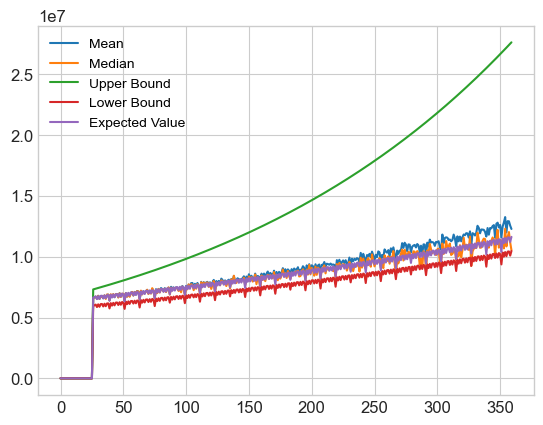

In [67]:
# Check the skewed Revenue - Regular Sales
plt.plot(df_sim_results.filter(regex='Revenue - Regular Sales_sim_').mean(axis=1), label='Mean')
plt.plot(df_sim_results.filter(regex='Revenue - Regular Sales_sim_').median(axis=1), label='Median')
plt.plot(df_pred.filter(regex='Revenue - Regular Sales - upper'), label='Upper Bound')
plt.plot(df_pred.filter(regex='Revenue - Regular Sales - lower'), label='Lower Bound')
plt.plot(df_pred.filter(regex='Revenue - Regular Sales - expected'), label='Expected Value')
plt.legend()

In [68]:
df_sim_results = get_tax_for_tax_related_columns(df_sim_results, iters)
df_sim_results

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\1969922956.py:29: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\1969922956.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\1969922956.py:29: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

,Revenue - Regular Sales_sim_0,Revenue - Regular Sales_sim_1,Revenue - Regular Sales_sim_2,Revenue - Regular Sales_sim_3,Revenue - Regular Sales_sim_4,Revenue - Regular Sales_sim_5,Revenue - Regular Sales_sim_6,Revenue - Regular Sales_sim_7,Revenue - Regular Sales_sim_8,Revenue - Regular Sales_sim_9,...,ebita_sim_95,tax_sim_95,ebita_sim_96,tax_sim_96,ebita_sim_97,tax_sim_97,ebita_sim_98,tax_sim_98,ebita_sim_99,tax_sim_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-228940.516291,0,-228287.870219,0,-227444.560365,0,-226368.169385,0,-225000.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-228966.903062,0,-227685.961567,0,-225371.605793,0,-225371.605793,0,-225371.605793,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-228615.013848,0,-228442.544387,0,-226673.623577,0,-225743.825323,0,-225743.825323,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-233179.535058,0,-232550.160649,0,-231970.531662,0,-231551.338464,0,-226116.659604,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-230148.826536,0,-226490.109651,0,-226490.109651,0,-226490.109651,0,-226490.109651,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,10037685.541192,...,9521945.845722,-2380486.46143,9809107.465321,-2452276.86633,9862343.803723,-2465585.950931,11271728.731603,-2817932.182901,15269878.169961,-3817469.54249
356,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,10413344.437623,...,12112861.714392,-3028215.428598,13280880.708846,-3320220.177212,14450797.902033,-3612699.475508,15487123.297536,-3871780.824384,17972015.000792,-4493003.750198
357,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,10430542.922587,...,11953925.021945,-2988481.255486,12834847.086932,-3208711.771733,14011242.502293,-3502810.625573,14212654.764613,-3553163.691153,14758097.656757,-3689524.414189
358,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,10087501.887686,...,12174449.489348,-3043612.372337,12350466.763524,-3087616.690881,12385268.126427,-3096317.031607,13296268.910796,-3324067.227699,14403820.602142,-3600955.150536


In [69]:
#df_sim_results
#
#for i in range(0,iters):    
#    parts = [df_sim_results.iloc[:, i:i+iters] for i in range(0, iters*int(variables), iters)]
#    shuffled_parts = []
#    npvs_list = []
#
#    for part in parts:
#        shuffled_part = part.sample(axis=1)
#        shuffled_parts.append(shuffled_part)
#
#    df_shuffled = pd.concat(shuffled_parts, axis=1)
#
#    ebitda = df_shuffled.filter(regex='ebitda').columns.values[0]
#    tax = df_shuffled.filter(regex='tax').columns.values[0]
#    investments = df_shuffled.filter(regex='Investments').columns.values[0]
#
#    cashflows = list(df_shuffled.loc[:,f'{ebitda}'] + df_shuffled.loc[:,f'{tax}'] 
#                         + df_shuffled.loc[:,f'{investments}'])
#    cashflows = [0] + cashflows # Investment is null
#    npvs_list.append(npf.npv(monthly_wacc/100, cashflows))
#npvs_list

In [70]:
# Make more fency (boundries blue, expected n): include variable name, etc.
#plot_simulations(df_sim_results.iloc[:,:iters].groupby(df_sim_results.index // 12), df_pred.iloc[:,:3].groupby(df_sim_results.index // 12))

In [71]:
# Make more fency (boundries blue, expected puple): include variable name, etc.
#plot_simulations(df_sim_results.iloc[:,1000:2000].groupby(df_sim_results.index // 12), df_predict_year.iloc[:,3:6].groupby(df_sim_results.index // 12))

In [72]:
#plot_simulations(df_sim_results.iloc[:,2000:3000].groupby(df_sim_results.index // 12), df_predict_year.iloc[:,6:9].groupby(df_sim_results.index // 12))

In [73]:
#plot_simulations(df_sim_results.iloc[:,4000:5000]/1000, df_predict_year.iloc[:,12:15]/1000)

In [74]:
#plot_simulations(df_sim_results.iloc[:,16000:17000]/1000, df_predict_year.iloc[:,48:51]/1000)

## Calculate NPVs

In [75]:
npvs = calculate_npv_simulations(df_sim_results, iters, monthly_wacc)
npvs

,npvs
npv_0,-3.457696e+07
npv_1,-3.306591e+07
npv_2,-3.064075e+07
npv_3,-2.764234e+07
npv_4,-2.474038e+07
...,...
npv_95,2.595453e+08
npv_96,2.718816e+08
npv_97,2.855488e+08
npv_98,3.029528e+08


## Density plot NPVs

In [76]:
[npv_exp, cashflows_exp, df_pred_exp] = calculate_expected_npv(df_pred, monthly_wacc)
npv_exp

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\1060991943.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\1060991943.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\1060991943.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

78488533.93220727

In [77]:
def plot_npv(npv_simulation_df, npv_expected):
    plt.figure(figsize=(6, 4))
    sns.distplot(npv_simulation_df/1000000, color = 'darkblue')
    plt.axvline(npv_expected/1000000, 0,int(pd.DataFrame(npv_simulation_df).max()),color='magenta', label='Expected NPV')

    # set the graph labels
    plt.ylabel("Probability density",fontsize=14)
    plt.xlabel("NPV (€ million)",fontsize=14)
    plt.title(f"NPV density, expected = €{round((npv_expected/1000000),1)}m", fontsize=18,fontweight="bold")
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.title("Cumulative Plot with Expected NPV = " + str(round(npv_exp,2)))
    sns.distplot(npv_simulation_df/1000000, color = 'darkblue', hist_kws={'cumulative':True},kde_kws={'cumulative':True})
    plt.axvline(npv_expected/1000000, 0,int(pd.DataFrame(npv_simulation_df).max()),color='magenta', label='Expected NPV')

    # set the graph labels
    plt.ylabel("Cumulative probability density",fontsize=14)
    plt.xlabel("NPV (€ million)",fontsize=14)
    plt.title(f"Cumulative NPV density, expected = €{round((npv_expected/1000000),1)}m", fontsize=18,fontweight="bold")
    plt.legend()

In [78]:
ll = pd.DataFrame(df_pred_exp.filter(regex='expected').mean())
ll

,0
Revenue - Regular Sales - expected,8.141114e+06
COGS - Regular Sales - expected,-2.757890e+06
COGS - Intermediate Sales - expected,-2.690590e+03
OPEX - Inventory Revaluation - expected,-3.972564e+03
OPEX - Energy costs - Sorting - expected,-1.057561e+05
OPEX - Energy costs - Recycling - expected,-5.427146e+05
OPEX - Real estate - expected,-3.411552e+05
OPEX - Insurance - expected,-6.000136e+04
OPEX - Disposal - expected,-4.296847e+05
OPEX - Waste water - expected,-1.160444e+05


In [79]:
hh = pd.DataFrame(df_sim_results.filter(regex=f'_sim_{50}$').mean())
hh

,0
Revenue - Regular Sales_sim_50,8.164643e+06
COGS - Regular Sales_sim_50,-2.755680e+06
COGS - Intermediate Sales_sim_50,-2.687959e+03
OPEX - Inventory Revaluation_sim_50,-3.970472e+03
OPEX - Energy costs - Sorting_sim_50,-1.056684e+05
OPEX - Energy costs - Recycling_sim_50,-5.423413e+05
OPEX - Real estate_sim_50,-3.408891e+05
OPEX - Insurance_sim_50,-5.993664e+04
OPEX - Disposal_sim_50,-4.292594e+05
OPEX - Waste water_sim_50,-1.159209e+05


C:\Users\ttruyts\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ttruyts\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



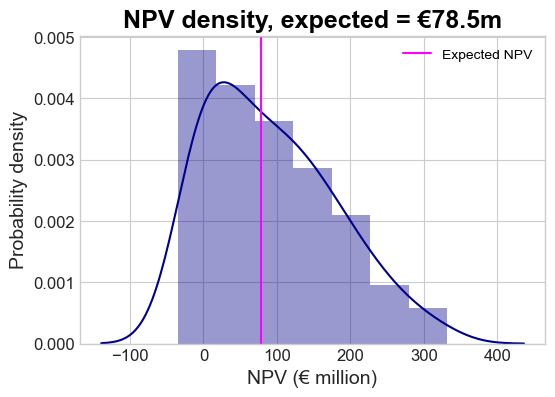

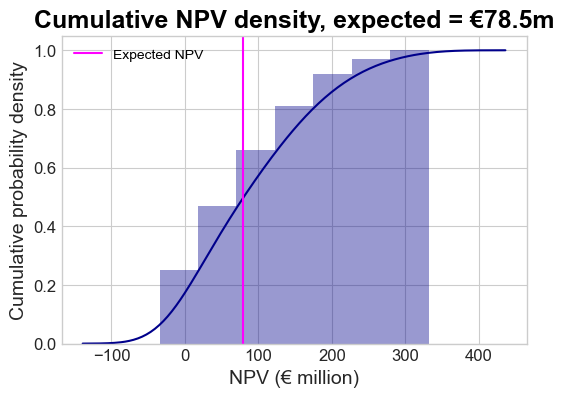

In [80]:
plot_npv(npvs, npv_exp)

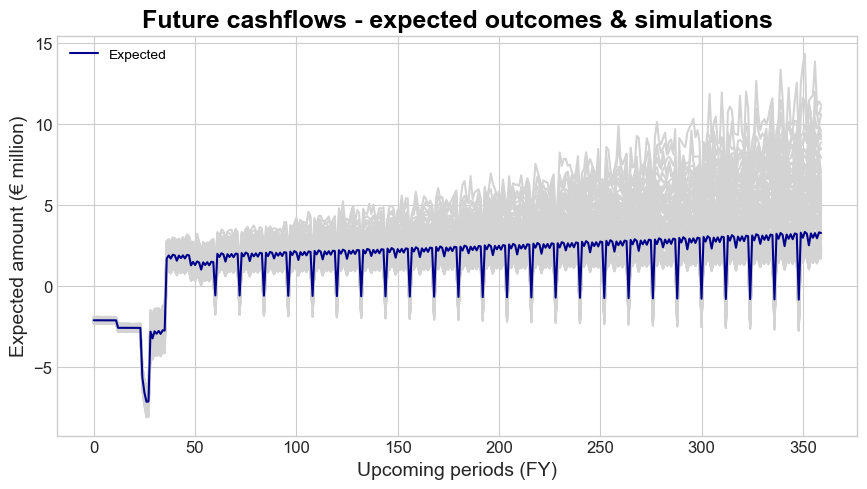

In [81]:
cahsflows_sim = plot_cashflows(df_sim_results, cashflows_exp, iters)

## Sensitivity

In [82]:
columnames

['Revenue - Regular Sales',
 'COGS - Regular Sales',
 'COGS - Intermediate Sales',
 'OPEX - Inventory Revaluation',
 'OPEX - Energy costs - Sorting',
 'OPEX - Energy costs - Recycling',
 'OPEX - Energy costs',
 'OPEX',
 'OPEX - Real estate',
 'OPEX - Insurance',
 'OPEX - Disposal',
 'OPEX - Waste water',
 'OPEX - Packaging',
 'OPEX - Internal transportation',
 'OPEX - Staff costs soritng',
 'OPEX - Staff costs recycling',
 'OPEX - Other',
 'DA - Depreciations',
 'Investments - Totals',
 'Change in NWC']

In [83]:
df_npv_input = plot_sensitivity(df_sim_results, columnames, monthly_wacc)

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\3173903072.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\3173903072.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\3173903072.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\3173903072.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ttruyts\AppData\Local\Temp\ipykernel_2636\3173903072.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [84]:
#df_sim_results 36155387

In [85]:
### OPEX?, Corporate income tax, kleuren?